In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.models.astromer_1 import get_ASTROMER
from src.utils import get_metrics
from matplotlib import gridspec
from src.data import get_loader
from src.data.zero import pretraining_pipeline

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2


2024-01-29 15:32:25.007197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
folder = './presentation/experiments/astromer_1/results/first/2024-01-28_21-31-12/'
exp_folders = glob.glob(os.path.join(folder, 'pretraining'))
exp_folders

['./presentation/experiments/astromer_1/results/first/2024-01-28_21-31-12/pretraining']

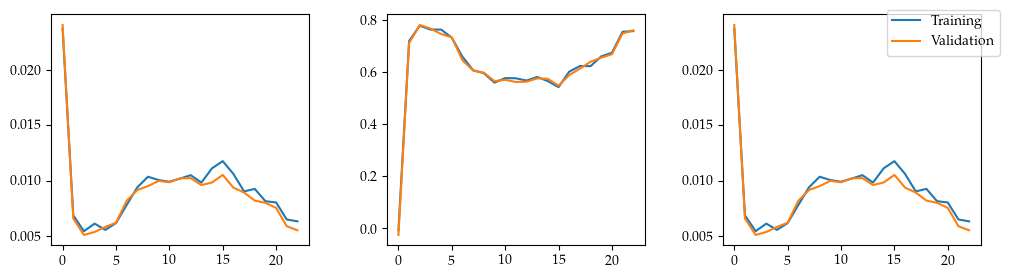

In [4]:
metric_names= ['epoch_loss', 'epoch_r_square', 'epoch_rmse']
format_metric_name = {
    'loss':'Loss',
    'r_square': 'R-square',
    'rmse': 'RMSE',
}

rows = []
fig, axes = plt.subplots(1, 3, figsize=(12, 3), 
                         gridspec_kw={'hspace': 0., 'wspace': 0.3}, sharex=True)
axes = axes.flatten()
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'tensorboard')
    with open(config_path, 'r') as f:
        config = toml.load(f)

        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), 
                                  metric_name='epoch_loss')
        best_epoch = val_metrics['value'].astype(float).argmin() 


        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

                axes[index].plot(train_metrics['step'], train_metrics['value'], label='Training')
                axes[index].plot(valid_metrics['step'], valid_metrics['value'], 
                                 label='Validation') 
#                 axes[index].set_yscale('log')
#                 axes[index].set_xscale('log')
                axes[index].set_ylabel(format_metric_name[metric])
                
                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)        
            except:
                continue
                
        rows.append(pd.Series(config))
axes[-1].legend(bbox_to_anchor=(1.1, 1.05))
results = pd.concat(rows, axis=1).T

# Reconstruction

In [14]:
with open(os.path.join(folder, 'pretraining', 'config.toml'), 'r') as file:
    config = toml.load(file)

    
astromer = get_ASTROMER(num_layers=config['num_layers'],
                 num_heads=config['num_heads'],
                 head_dim=config['head_dim'],
                 mixer_size=config['mixer'],
                 dropout=config['dropout'],
                 pe_base=config['pe_base'],
                 pe_dim=config['pe_dim'],
                 pe_c=config['pe_exp'],
                 window_size=config['window_size'],
                 mask_format=config['mask_format'])
astromer.load_weights(os.path.join(folder, 'pretraining', 'weights'))

In [15]:
DATA = './data/records/macho_clean/test/'

test_loader = get_loader(DATA,
                         batch_size=256,
                         window_size=config['window_size'],
                         probed_frac=config['probed'],
                         random_frac=config['rs'],
                         sampling=False,
                         shuffle=False,
                         repeat=1,
                         aversion=config['encoder_mode'])

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


In [17]:
predictions = astromer.predict(test_loader.take(4))

4/4 [==============================] - 5s 1s/step


In [19]:
predictions['magnitudes'].shape,predictions['reconstruction'].shape

((1024, 200, 1), (1024, 200, 1))

In [33]:
'{:.2f} - {:.2f}'.format(
    mean_squared_error(predictions['magnitudes'][..., 0], predictions['reconstruction'][..., 0], squared=True), 
    r2_score(predictions['magnitudes'][..., 0], predictions['reconstruction'][..., 0]))

'0.01 - 0.68'

Text(0.96, 0.5, 'Predicted Magnitude')

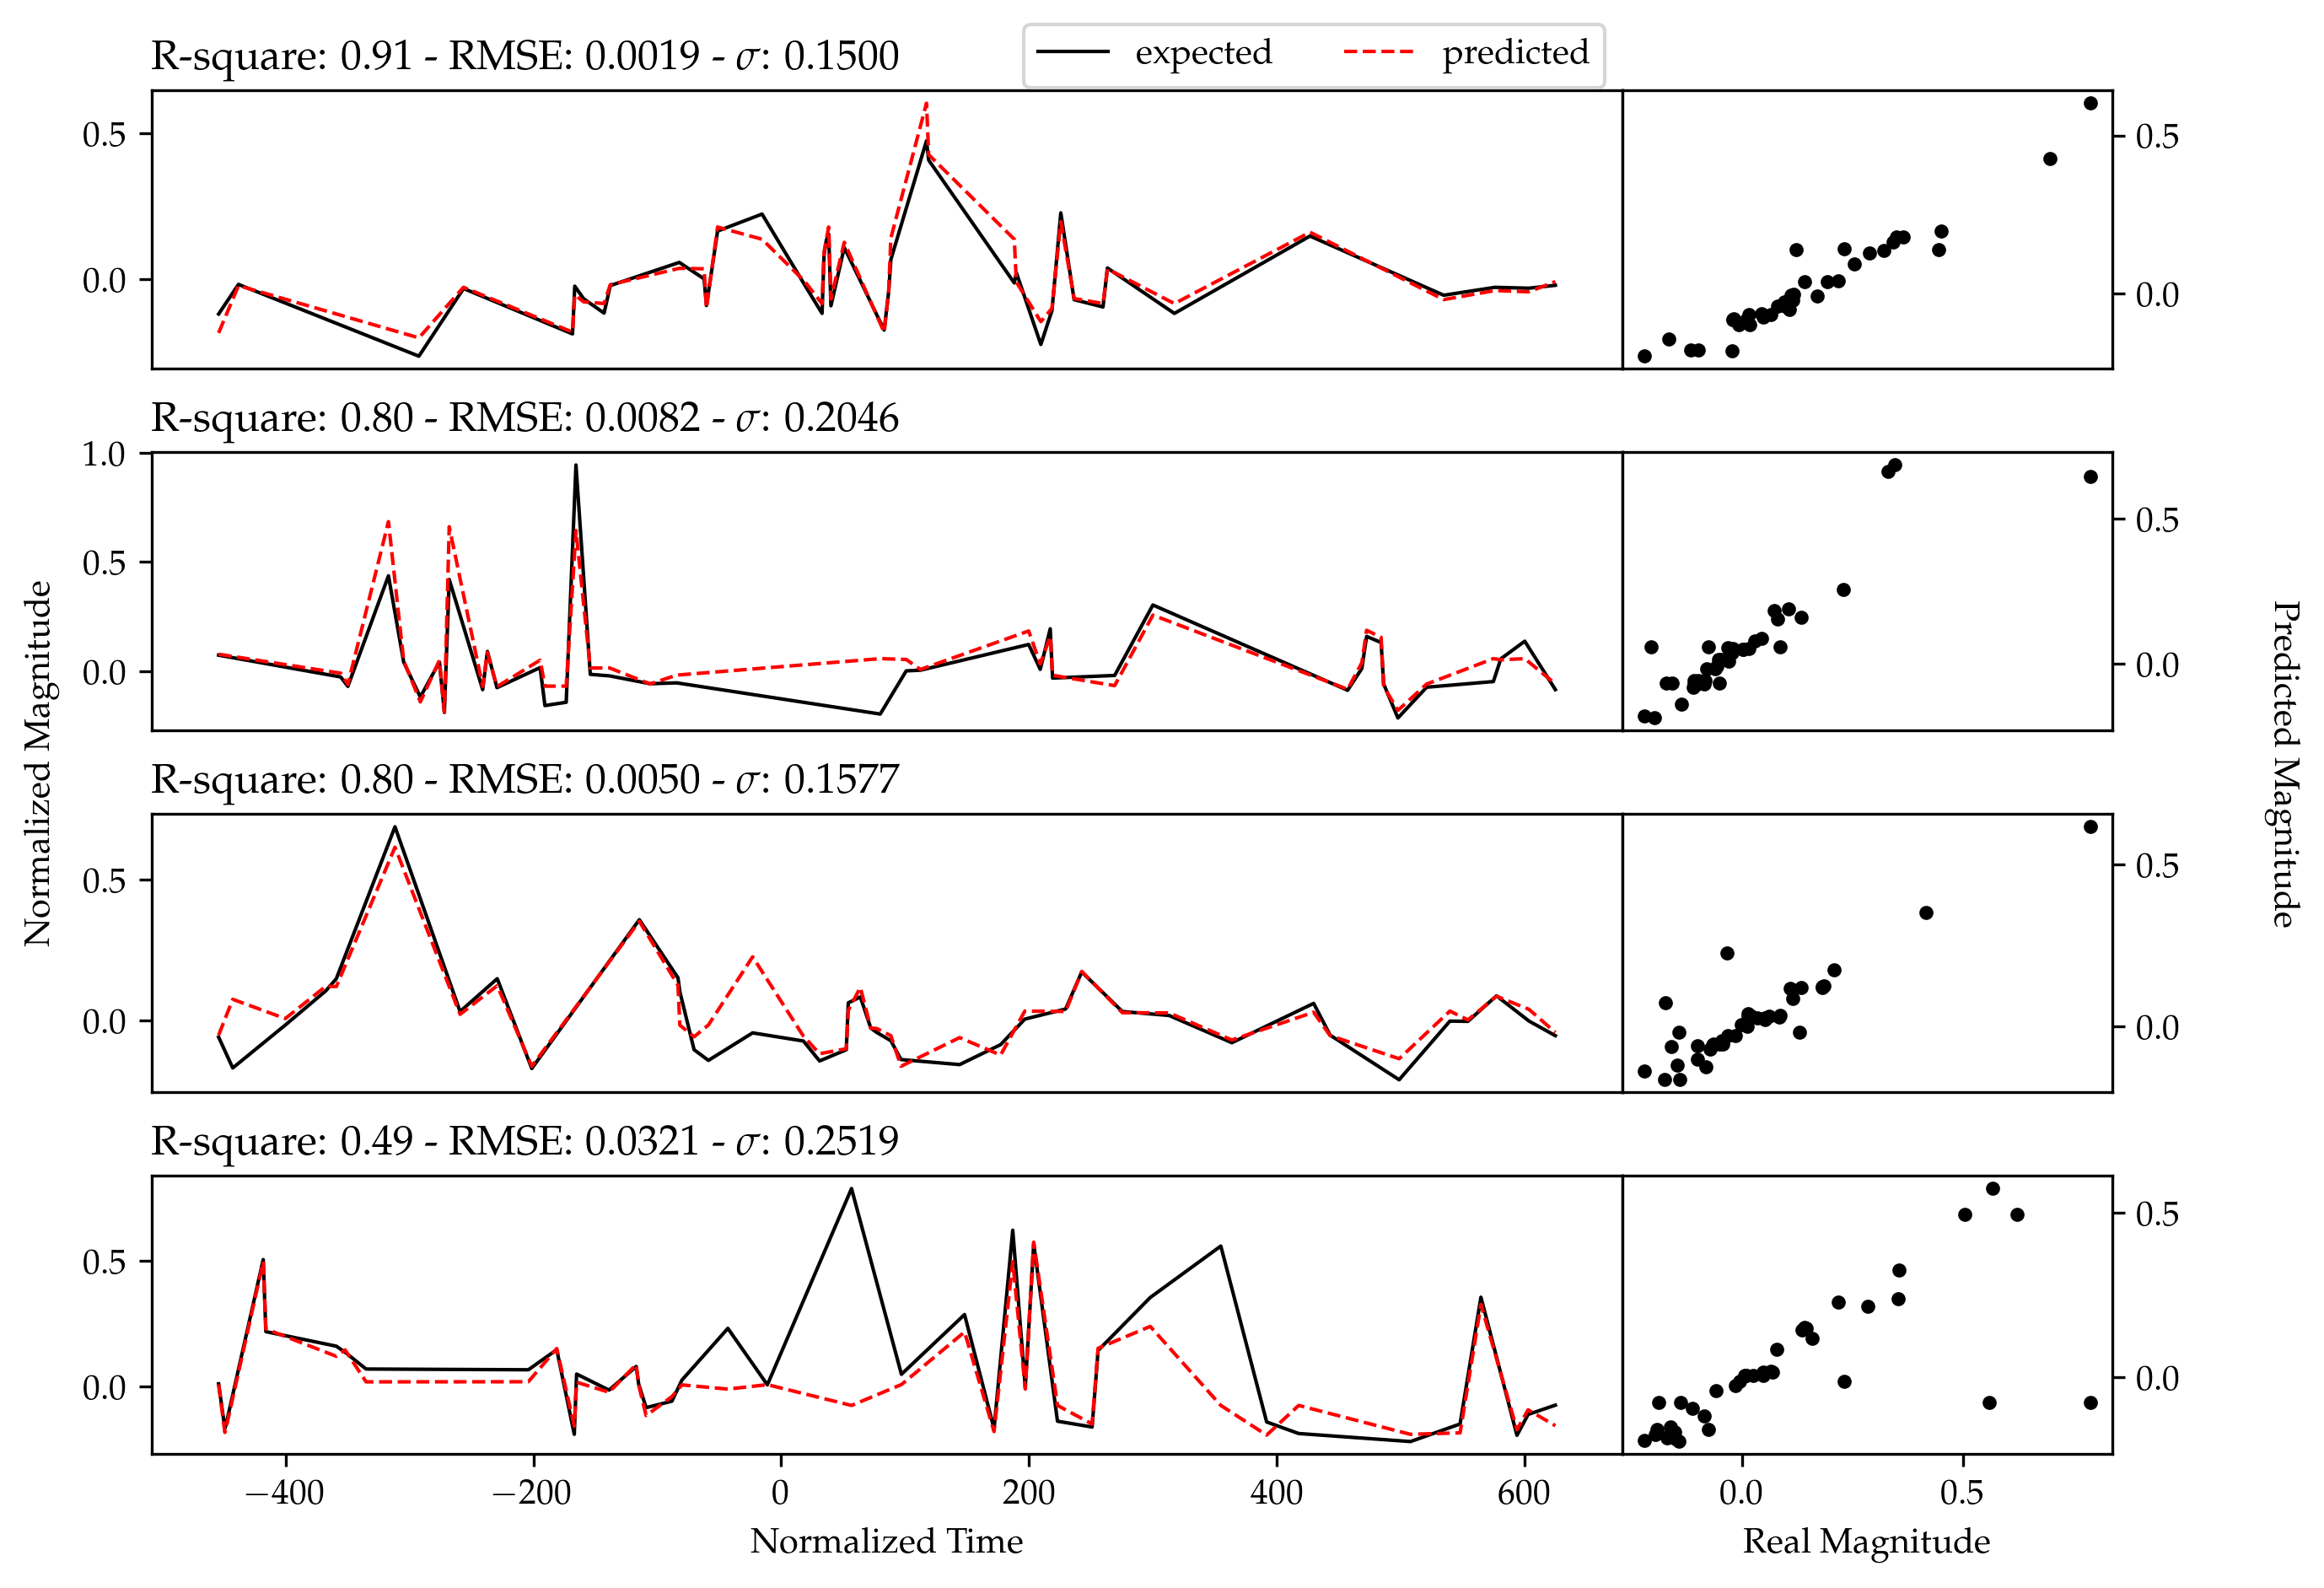

In [32]:
N = 4                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
gs.hspace = 0.3
gs.wspace = 0.
plt.subplots_adjust(hspace=0.2, wspace=0.05)

for i, x, y, m, t in zip(range(N), 
                      predictions['magnitudes'], 
                      predictions['reconstruction'], 
                      predictions['probed_mask'],
                      predictions['times']):
    
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])

    probed_true  = tf.boolean_mask(x[..., 0], m[..., 0])
    probed_pred  = tf.boolean_mask(y[..., 0], m[..., 0])
    sampling_times  = tf.boolean_mask(t[..., 0], m[..., 0])
    
    r2_val   = r2_score(probed_true, probed_pred)
    rmse_val = mean_squared_error(probed_true, probed_pred, squared=True)
    
    ax0.plot(sampling_times, probed_true, marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(sampling_times, probed_pred, marker='', linewidth=1, linestyle='--', color='r', label='predicted')
    ax1.plot(probed_true, probed_pred, '.', color='k')
    ax0.set_title('R-square: {:.2f} - RMSE: {:.4f} - $\sigma$: {:.4f}'.format(r2_val, 
                                                                          rmse_val, 
                                                                          tf.math.reduce_std(probed_true)), loc='left')
    
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 

    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)